HDB Scan


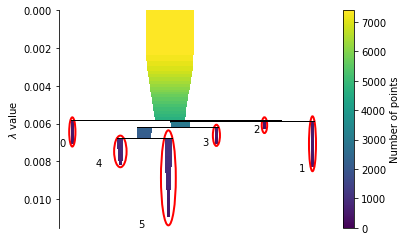

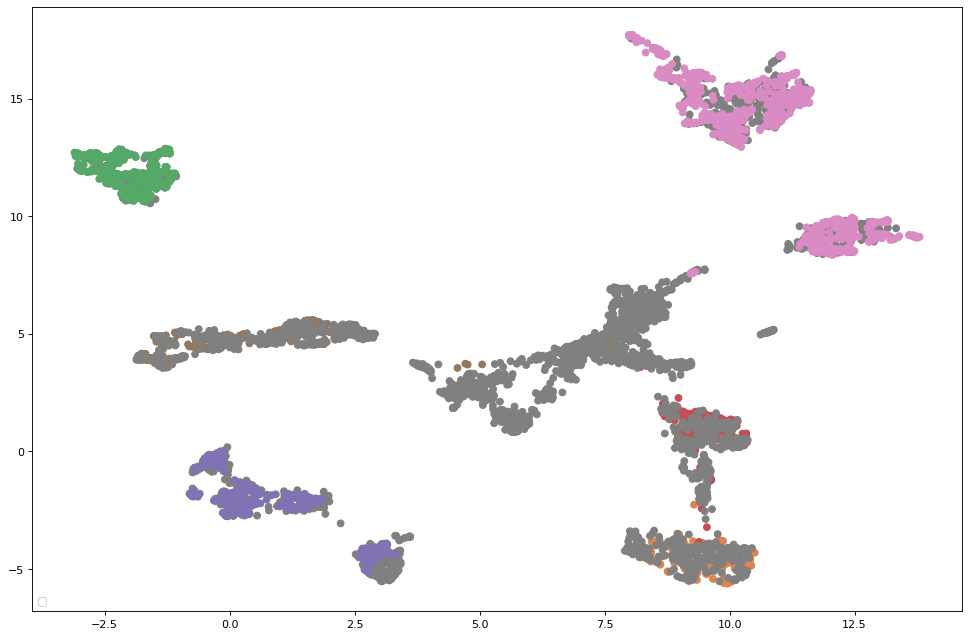

0.4474218432805522


In [2]:
import json
import pandas as pd
import hdbscan
import numpy as np
from TFTClusterer import TFTClusterer
from datetime import datetime, timedelta
from googledrivesave import trashfolder, outputtodrive
import pygsheets
from SQLGatherer import loaddb
from matplotlib import pyplot as plt
df = loaddb(hours=10)
gameversion = df['game_version'].max()
df=df.loc[df['game_version']==gameversion]

assert len(df) >= 100, "less than 100 matches in newest patch"
#Cluster Data

clusterclass=TFTClusterer(df)
#clusterclass.imputetraits()
clusterclass.reduce_dimension()
clusterclass.cluster(divisor=20, cluster_selection_epsilon=0)

clusterclass.eval_clustering()
clusterclass.plot.figure.savefig('fig.png')
pd.DataFrame(clusterclass.clusterdf.groupby('hdbnumber')['hdb'].value_counts()).to_csv('hdbnumber.csv')
print(sum(clusterclass.clusterdf['hdbnumber']==0)/len(clusterclass.clusterdf))

#output Files for Power BI
clusterclass.unitshdb.to_csv("unitshdb.csv",index=False)
clusterclass.itemshdb.to_csv("itemshdb.csv",index=False)
clusterclass.clusterdf[["comp_id","participants.placement","hdb","game_variation"]].to_csv("hdb.csv",index=False)

#Write newest date
f = open('newestdate.csv','w')
f.write(str(datetime.fromtimestamp(df['game_datetime'].max()/1e3))) #Give your csv text here.
f.close()



In [3]:
clusterclass.clusterdf['hdb'].value_counts()

No Comp                   3306
Vanguard Sniper           1142
Blademaster Celestial      958
Brawler Rebel              546
Cybernetic Chrono          540
Mech-Pilot Infiltrator     480
Star Guardian Sorcerer     417
Name: hdb, dtype: int64

In [6]:
import umap
cols = clusterclass.unitscol + clusterclass.traitscol
reducer = umap.UMAP(metric = 'manhattan', random_state = 42, n_components = 10)
clusterdf = clusterclass.clusterdf.fillna(0)
embed = reducer.fit_transform(clusterdf[cols])

In [7]:
embed

array([[ 6.239023 , -1.8810096,  6.0905676, ...,  0.8792413,  7.5313783,
         2.0259051],
       [ 5.8816757, -2.2267935,  6.253098 , ...,  1.0055355,  7.154385 ,
         1.6980336],
       [ 5.882113 , -2.2051358,  6.3194213, ...,  0.9765977,  7.1928444,
         1.6696956],
       ...,
       [10.146029 ,  9.957007 ,  7.0679955, ...,  3.910651 ,  7.25836  ,
         4.720131 ],
       [ 9.615483 ,  9.020654 ,  6.3371563, ...,  3.3146431,  7.3692894,
         4.185373 ],
       [10.903229 , 10.684169 ,  7.629524 , ...,  4.186606 ,  6.467297 ,
         5.0371842]], dtype=float32)

In [17]:
len(embed)

7389

In [28]:
clusterdf = clusterclass.clusterdf

In [29]:
x = 0
for i in range(10):
    clusterdf['embed_' + str(x)] = embed[:,x]
    x = x + 1

In [30]:
clusterdf

,match_id,participants.placement,game_variation,TFT3_Ahri,TFT3_Annie,TFT3_Ashe,TFT3_AurelionSol,TFT3_Bard,TFT3_Blitzcrank,TFT3_Caitlyn,...,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_0
0,EUW1_4730428321,1,Superdense Galaxy,NaN,56.925,NaN,68.54,NaN,NaN,NaN,...,-1.881010,6.090568,10.672076,6.736064,5.862685,5.290687,0.879241,7.531378,2.025905,6.239023
1,EUW1_4730429244,6,Galactic Armory,NaN,56.925,NaN,NaN,NaN,NaN,NaN,...,-2.226794,6.253098,9.854483,7.064253,6.128665,5.220059,1.005535,7.154385,1.698034,5.881676
2,EUW1_4730447832,8,Trade Sector,NaN,56.925,NaN,NaN,NaN,NaN,NaN,...,-2.205136,6.319421,9.882258,7.002708,6.111239,5.285516,0.976598,7.192844,1.669696,5.882113
3,EUW1_4730506491,7,Plunder Planet,NaN,56.925,NaN,NaN,NaN,NaN,NaN,...,-2.756027,5.546306,10.479452,7.342063,6.036440,5.064377,0.829501,7.097673,2.070216,6.431574
4,EUW1_4730703417,6,Star Cluster,NaN,56.925,NaN,NaN,NaN,NaN,NaN,...,-2.426519,6.235795,10.150109,6.962417,6.199880,5.455295,0.920733,7.196559,1.804316,6.182295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7384,TR1_1048321360,6,Normal Game,NaN,NaN,NaN,NaN,60.375,NaN,NaN,...,7.035006,5.534332,3.471721,4.955151,3.719847,4.506683,1.700805,7.517114,3.499471,8.063876
7385,TR1_1048321360,8,Normal Game,NaN,NaN,60.375,NaN,NaN,NaN,NaN,...,6.159921,6.201565,4.318939,4.886122,4.672714,6.481301,2.486186,7.724732,3.495847,7.264085
7386,TR1_1048322864,2,Plunder Planet,NaN,NaN,60.375,NaN,NaN,NaN,13.11,...,9.957007,7.067996,1.792818,7.074836,6.171782,8.342718,3.910651,7.258360,4.720131,10.146029
7387,TR1_1048322864,4,Plunder Planet,NaN,NaN,NaN,NaN,60.375,NaN,NaN,...,9.020654,6.337156,2.243926,6.516163,5.445518,7.378922,3.314643,7.369289,4.185373,9.615483
